This notebook is related to a series of other notebooks

- [Data preprocessing](https://www.kaggle.com/code/db0boy/lending-club-loan-data-cleared-preparation) 

- [Adding new features and splitting data](https://www.kaggle.com/code/db0boy/credit-scoring-data-processing)

- [Constructing interpreted logistic regression](https://www.kaggle.com/code/db0boy/credit-scoring-interpretable-model)

- Building uninterpreted models

Also, all notebooks are linked to [this repository](https://github.com/boyfws/Predicting-default)

# Loading files from repository

In [1]:
!git clone --depth 1 https://github.com/boyfws/Predicting-default
!pip install -r /kaggle/working/Predicting-default/requirements.txt -q
!pip install ortools==9.7.2996 -q

Cloning into 'Predicting-default'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 0), reused 17 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 6.82 MiB | 23.05 MiB/s, done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB

# Imports

## Base

In [2]:
import pandas as pd
import numpy as np
import random 

import warnings
from dataclasses import dataclass
from pathlib import Path
import sys
import os

## Modules from repo

In [3]:
sys.path.append("/kaggle/working/Predicting-default")
from Validator import Validator
from BoosterWrapper import BoosterWrapper
from utils import classification_report
from ExpectedIncome import IncomePredictor

## Torch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Sklearn

In [5]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

## Other 

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

# Config 

## Config class 

In [7]:
@dataclass(frozen=True)
class Config:
    seed = 42
    n_jobs = -1

## Configure env

In [8]:
random.seed(Config.seed)  # Python
np.random.seed(Config.seed)  # NumPy
torch.manual_seed(Config.seed)  # CPU
torch.cuda.manual_seed(Config.seed)  # Single GPU
torch.cuda.manual_seed_all(Config.seed)  # Multi-GPU

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["PYTHONHASHSEED"] = str(Config.seed)

warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading data

In [9]:
base_path = Path("/kaggle/input/credit-scoring-data-processing")
for el in ["train", "test", "val"]:
    globals()[f"X_{el}"] = pd.read_csv(base_path / f"X_{el}.csv").drop("emp_title", axis=1)
    globals()[f"y_{el}"] = np.load(base_path / f"y_{el}.npy")

# Сolumn deletion 

Just as in the notebook with the interpreted model, let's remove some of the features with weak predictive power 

In [10]:
good_features = [
    "issue_date_month_num_sin",
    "mths_since_recent_bankcard_delinq",
    "mths_since_recent_revol_delinq",
    "num_inq_in_12mths",
    "num_30+_delinq_in_2yrs",
    "num_inc_in_fund_amnt",
    "num_derogatory_pub_rec",
    "max_bal_owed",
    "total_credit_revolving_bal",
    "num_inq_in_6mths",
    "mths_since_last_delinq",
    "num_rev_trades_op_in_24mths",
    "funded_amnt",
    "max_bal_owed_per_income",
    "total_credit_revolving_bal_per_income",
    "issue_date_month_num_cos",
    "num_rev_trades_op_in_12mths",
    "num_open_trades_in_6mths",
    "num_open_credit_lines",
    "annual_income",
    "num_inq",
    "mths_since_last_installment_acc_op",
    "loan_term_months"
] + X_train.select_dtypes(exclude="number").columns.to_list()

In [11]:
X_train = X_train[good_features]
X_test = X_test[good_features]
X_val = X_val[good_features]

In [12]:
X_train.select_dtypes(exclude="number").columns.to_list()

['emp_length',
 'home_ownership_status',
 'verification_status',
 'loan_purpose',
 'addr_state',
 'initial_list_status',
 'disbursement_method',
 'issue_date_month',
 'earliest_cr_line_month',
 'earliest_cr_line_full']

# Data pipeline 

In [13]:
na_sum = X_train.isna().sum() + X_test.isna().sum() + X_val.isna().sum()
na_cols = na_sum[na_sum != 0].index.to_list()
na_cols

['mths_since_recent_bankcard_delinq',
 'mths_since_recent_revol_delinq',
 'max_bal_owed',
 'mths_since_last_delinq',
 'num_rev_trades_op_in_24mths',
 'max_bal_owed_per_income',
 'num_rev_trades_op_in_12mths',
 'num_open_trades_in_6mths',
 'num_inq',
 'mths_since_last_installment_acc_op',
 'emp_length']

In [14]:
cat_one_hot = [
    "home_ownership_status",
    "verification_status",
    "loan_purpose",
    "addr_state",
    "initial_list_status",
    "disbursement_method",
]

cat_ord = [
    "emp_length",
    "issue_date_month",
    "earliest_cr_line_month"
]

cols_to_delete = [
    "earliest_cr_line_full"
]


na_cols = [
    el 
    for el in na_cols
    if el not in cat_one_hot
    and el not in cat_ord
    and el not in cols_to_delete
]
na_cols

['mths_since_recent_bankcard_delinq',
 'mths_since_recent_revol_delinq',
 'max_bal_owed',
 'mths_since_last_delinq',
 'num_rev_trades_op_in_24mths',
 'max_bal_owed_per_income',
 'num_rev_trades_op_in_12mths',
 'num_open_trades_in_6mths',
 'num_inq',
 'mths_since_last_installment_acc_op']

In [15]:
cols_order = [
    ['__MISSING__', '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
]

In [16]:
def column_deleter(X: pd.DataFrame) -> pd.DataFrame:
    X = X.drop(cols_to_delete, axis=1)
    return X

In [17]:
col_deleter = FunctionTransformer(
    func=column_deleter,
    validate=False,         
    accept_sparse=False,    
)

nan_handler = FeatureUnion([
    ('imputer', SimpleImputer(strategy='mean')),
    ('missing_flags', MissingIndicator(features='all'))
])

nan_one_hot = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value="__MISSING__")),
    ("one_hot", OneHotEncoder(sparse_output=False, drop="if_binary"))
])

nan_ordinal = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value="__MISSING__")),
    ("ordinal", OrdinalEncoder(categories=cols_order))
])


col_preprocessor = ColumnTransformer(
    transformers=[
        (
            'one_hot', 
            nan_one_hot,
            cat_one_hot
        ),
        (
            "ordinal", 
            nan_ordinal,
            cat_ord
        ),
        (
            "nan",
            nan_handler,
            na_cols
        )
    ],
    remainder='passthrough',  
    n_jobs=-1,  
    verbose=False,  
    verbose_feature_names_out=False 
)

col_preprocessor.set_output(transform='pandas')


pipeline = Pipeline([
    ("delete_cols", col_deleter),
    ("transf_cols", col_preprocessor),
    ("scaler", StandardScaler())
])

In [18]:
X_train_trans = pipeline.fit_transform(X_train)
X_test_trans = pipeline.transform(X_test)
X_val_trans = pipeline.transform(X_val)


assert X_train_trans.shape[1] == X_test_trans.shape[1] == X_val_trans.shape[1]

# Baseline 

Let's use gradient bousting as our baseline

In [19]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    eval_metric='logloss',
    random_state=42
    
)

model.fit(
    X_train_trans, 
    y_train, 
    verbose=10,
    eval_set=[(X_test_trans, y_test)]
);

[0]	validation_0-logloss:0.37154
[10]	validation_0-logloss:0.34969
[20]	validation_0-logloss:0.34149
[30]	validation_0-logloss:0.33745
[40]	validation_0-logloss:0.33538
[50]	validation_0-logloss:0.33385
[60]	validation_0-logloss:0.33327
[70]	validation_0-logloss:0.33264
[80]	validation_0-logloss:0.33210
[90]	validation_0-logloss:0.33168
[99]	validation_0-logloss:0.33151


## Test classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.663
Brier Score 0.093
Divergence Score 0.318

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



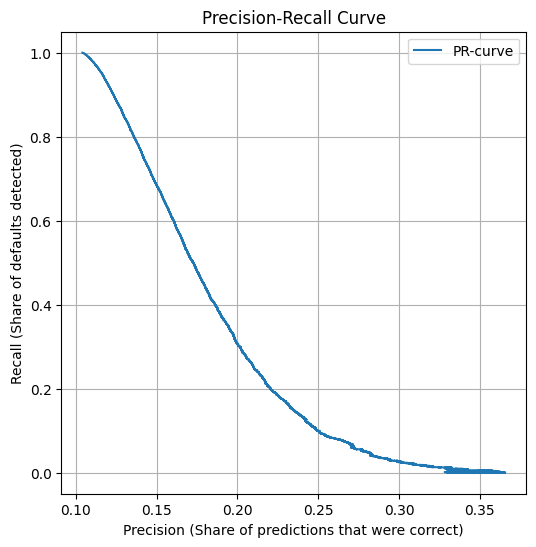


--------------------------------------------------
F1 Curve
--------------------------------------------------



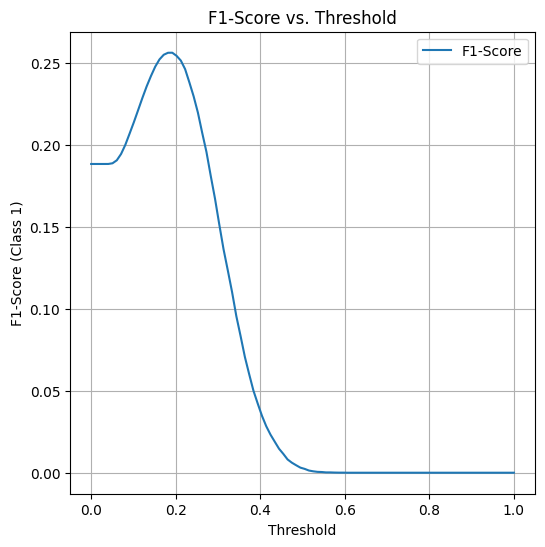


--------------------------------------------------
Calibration Curve
--------------------------------------------------



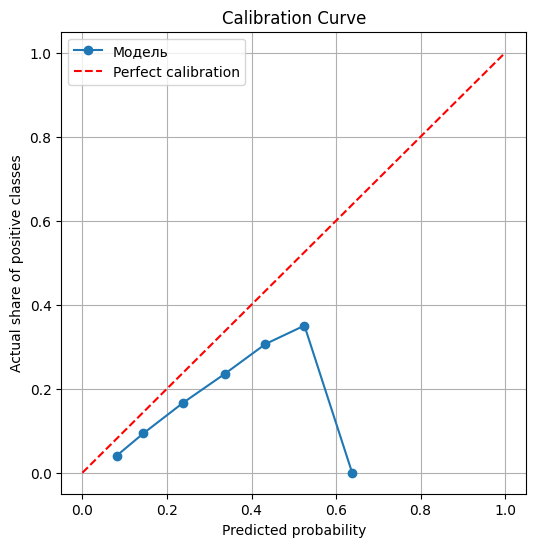

In [20]:
classification_report(
    y_test, 
    model.predict_proba(X_test_trans)[:, 1], 
    figsize=(6, 6)
)

## Val classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.667
Brier Score 0.047
Divergence Score 0.336

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



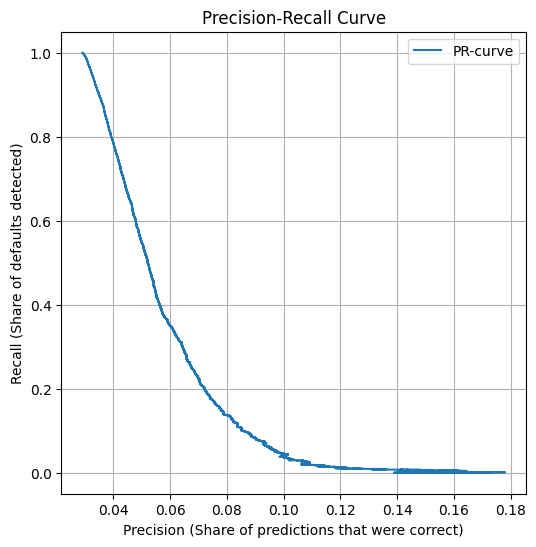


--------------------------------------------------
F1 Curve
--------------------------------------------------



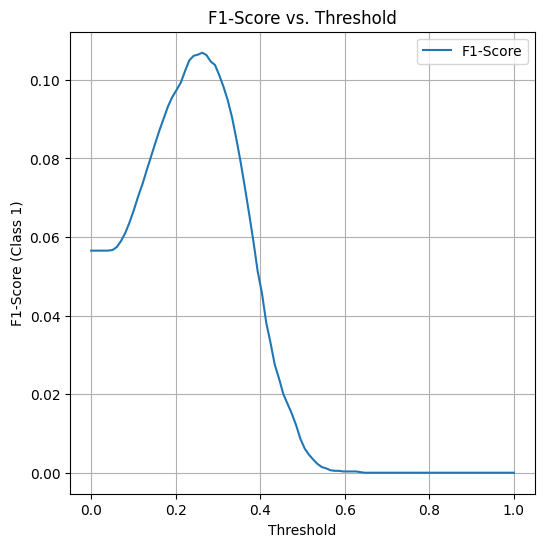


--------------------------------------------------
Calibration Curve
--------------------------------------------------



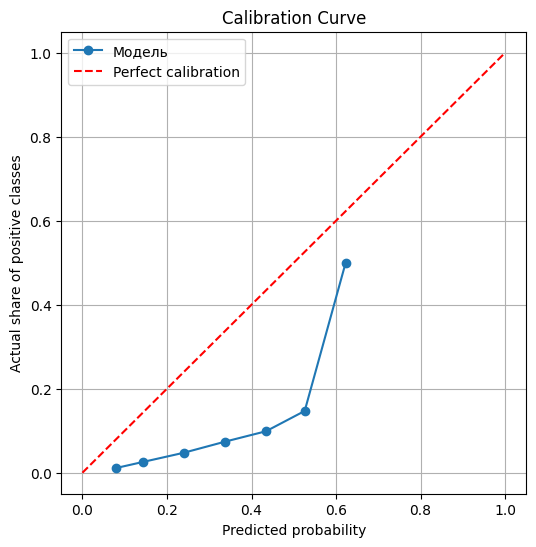

In [21]:
classification_report(
    y_val, 
    model.predict_proba(X_val_trans)[:, 1], 
    figsize=(6, 6)
)

# DBDT

In [22]:
loss_fn = nn.BCEWithLogitsLoss(
    reduction="sum"
)

def Loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return loss_fn(logits, targets.unsqueeze(-1))

In [23]:
class DBDT(BoosterWrapper):
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        pred = super().predict(X).reshape(-1)
        neg_pred_exp_p1 = 1 + np.exp(-pred)
        return 1 / neg_pred_exp_p1


model = DBDT(
    input_dim=X_train_trans.shape[1],
    output_dim=1,
    depth=5,
    n_estimators=100,
    booster_learning_rate=0.3,
    regularization_coef=0.0,
    epochs=10,
    batch_size=2 ** 15,
    learning_rate_value=1e-2,
    learning_rate_splitter=1e-3,
    loss=Loss,
    verbose=True,
    reg_lambda=0.5,
    t=1,
    compile=True,
    compile_params=dict(
        fullgraph=True, 
    ),
)

In [24]:
X_train_np = X_train_trans.astype(np.float32)

In [25]:
model.fit(X_train_np, y_train) 

Epoch 10/10: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s, Epoch Loss=0.4324]


## Test classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.674
Brier Score 0.093
Divergence Score 0.357

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



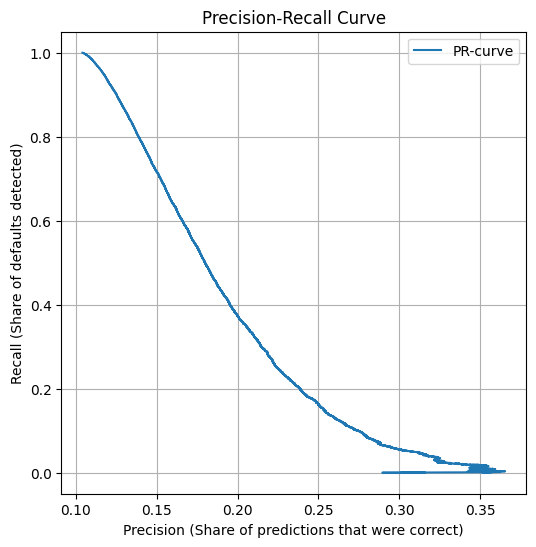


--------------------------------------------------
F1 Curve
--------------------------------------------------



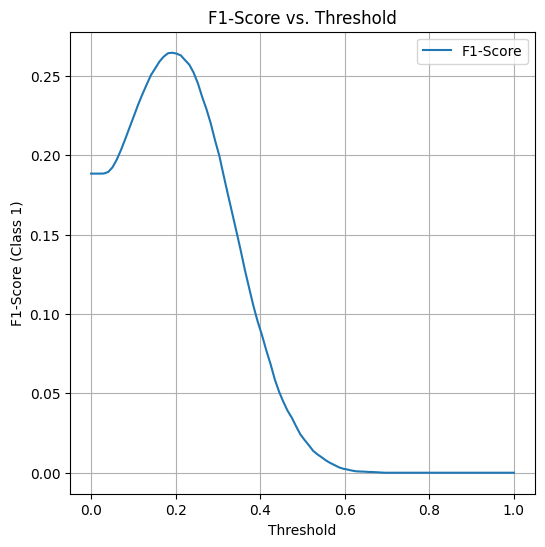


--------------------------------------------------
Calibration Curve
--------------------------------------------------



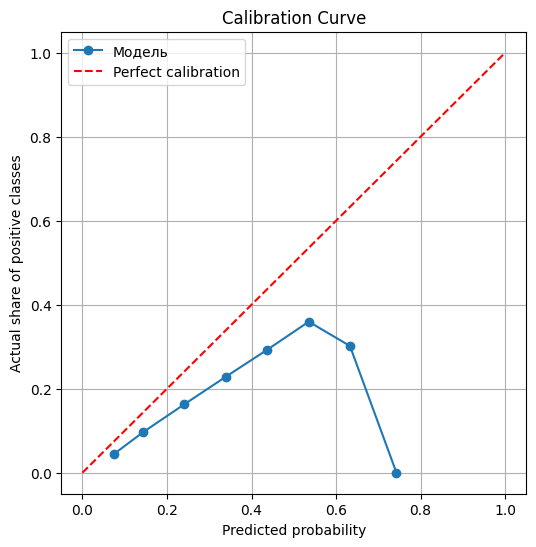

In [26]:
classification_report( 
    y_test,  
    model.predict_proba(
        X_test_trans.astype(np.float32)
    ), 
    figsize=(6, 6)
) 

## Val classification report

--------------------------------------------------
Metrics
--------------------------------------------------

ROC AUC 0.673
Brier Score 0.050
Divergence Score 0.371

--------------------------------------------------
Precision Recall Curve
--------------------------------------------------



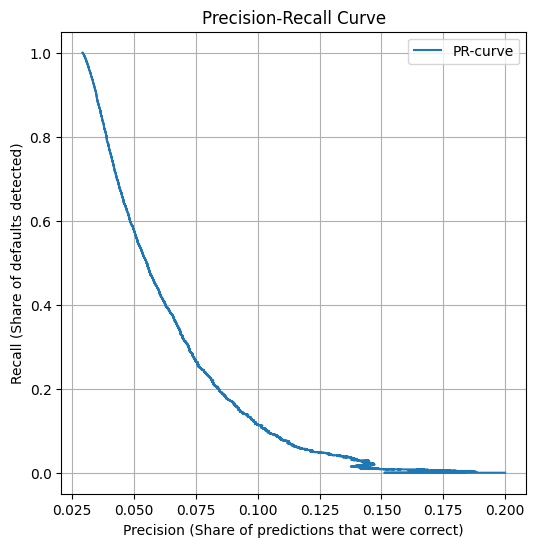


--------------------------------------------------
F1 Curve
--------------------------------------------------



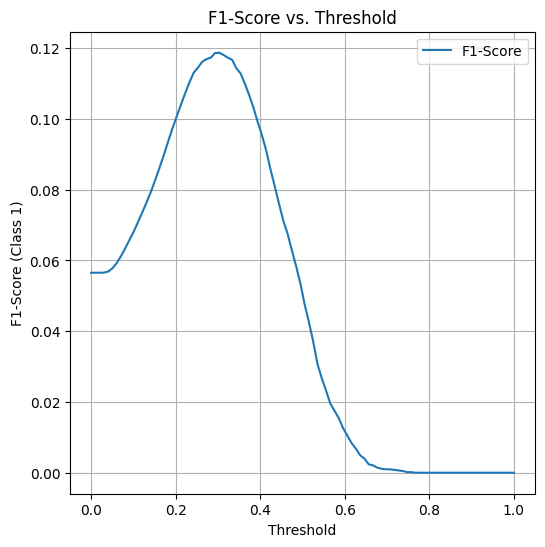


--------------------------------------------------
Calibration Curve
--------------------------------------------------



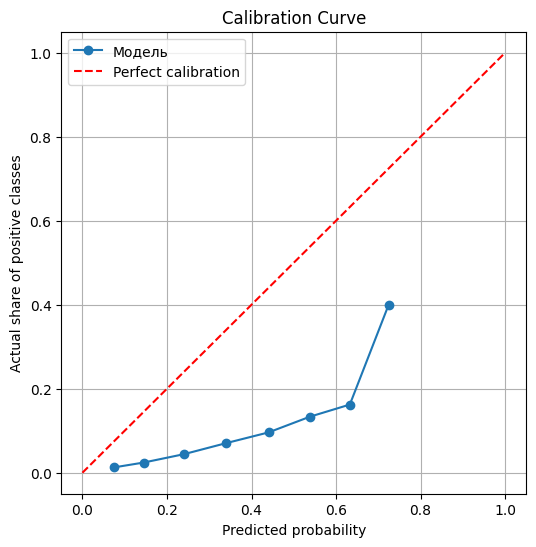

In [27]:
classification_report(
    y_val, 
    model.predict_proba(
        X_val_trans.astype(np.float32)
    ), 
    figsize=(6, 6)
)

## Validation 

In [28]:
validator = Validator(
    plot_graphs=True,
    figsize=(12, 12),
    n_jobs=-1,
) 

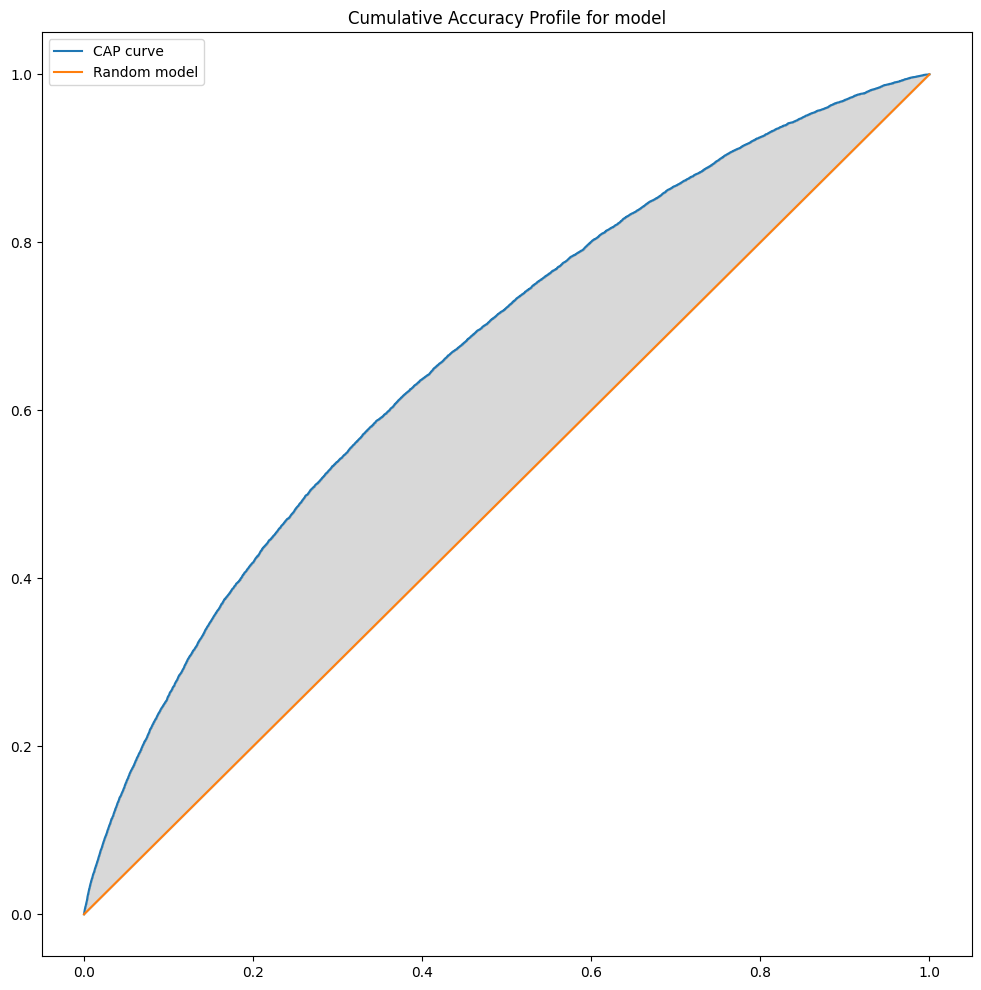

╭─────────────────────────────────────────────── General Gini test ───────────────────────────────────────────────╮
│ ⚠️ Intermediate result with gini 0.34                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

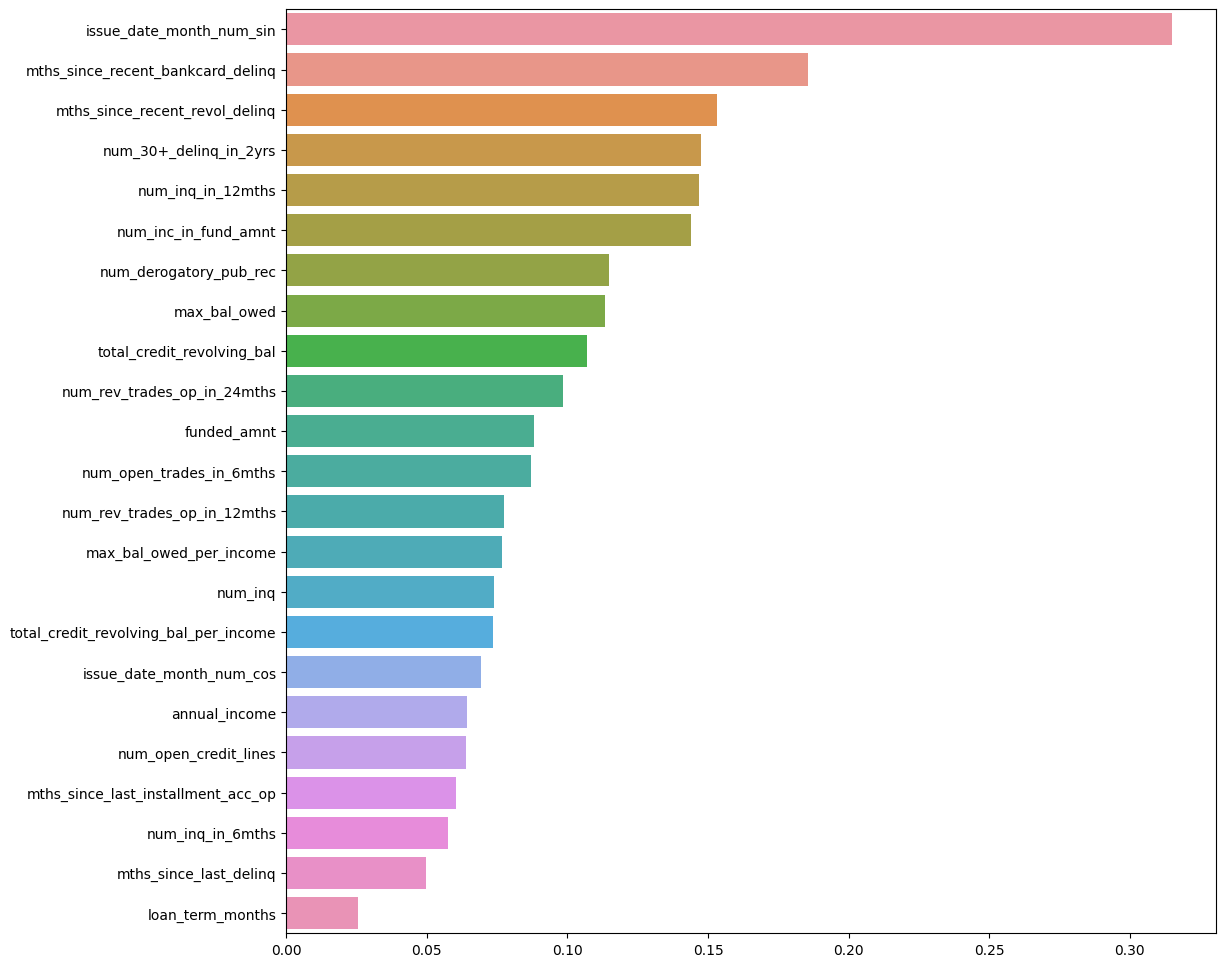

╭─────────────────────────────────────────────── Feature Gini test ───────────────────────────────────────────────╮
│ ⚠️ Intermediate result with red, yellow, green shares 0.09, 0.52, 0.39                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

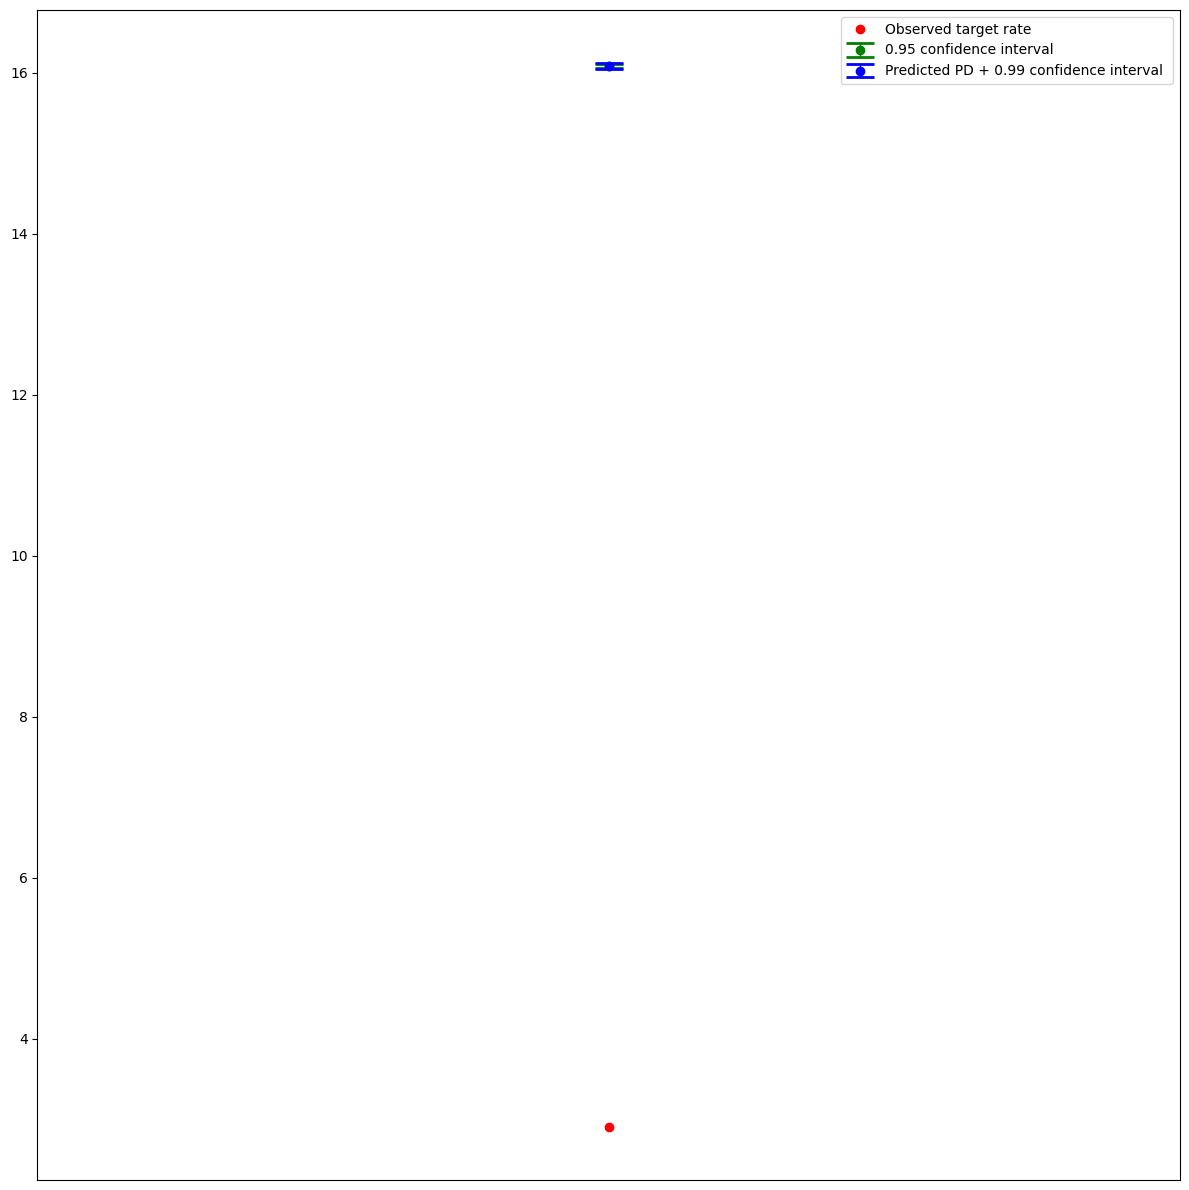

╭─────────────────────────────────────────────── Target Rate test ────────────────────────────────────────────────╮
│ ❌ Test failed with share 452.94%                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

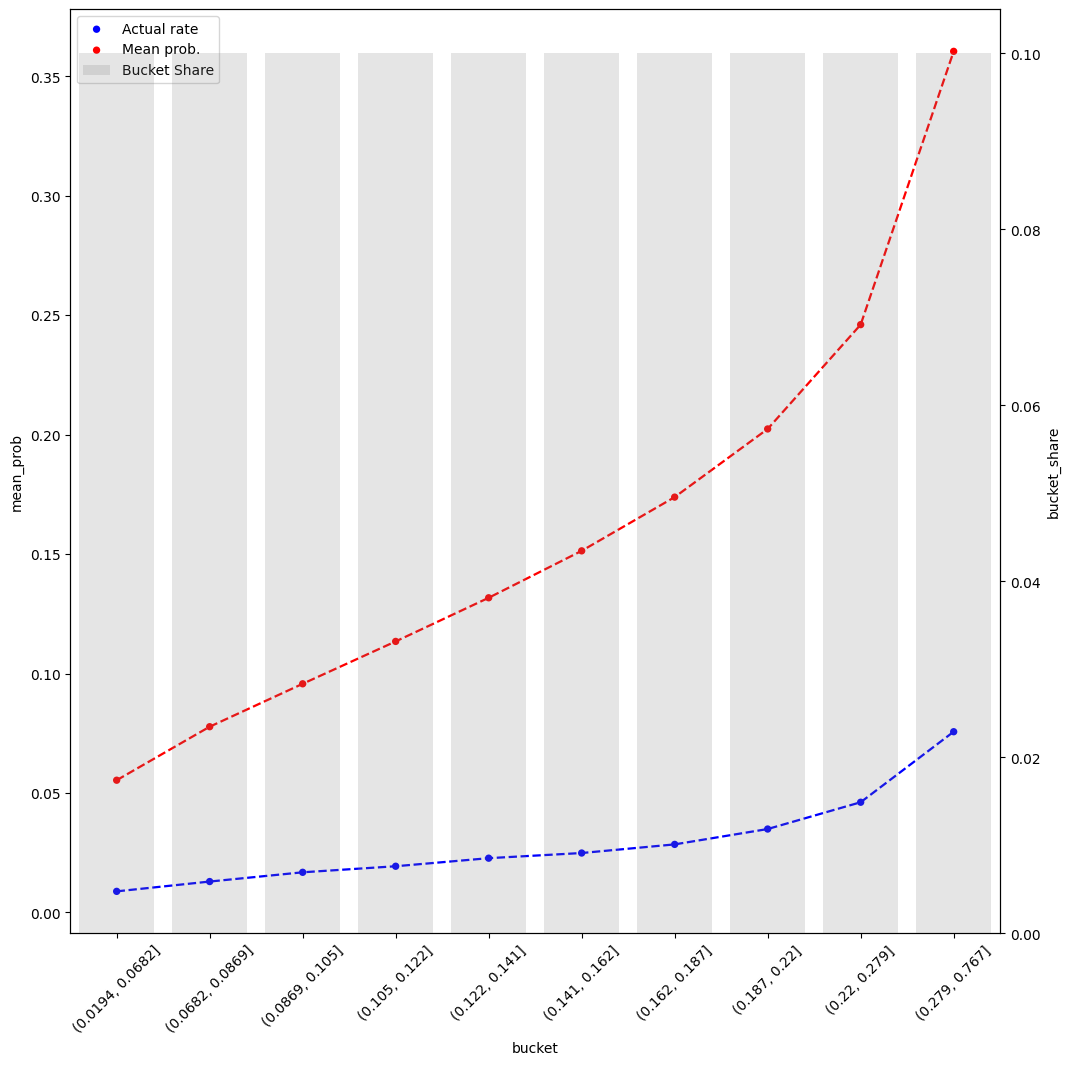

╭──────────────────────────────────────────── Calibration Curve test ─────────────────────────────────────────────╮
│ ❌ Test failed                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

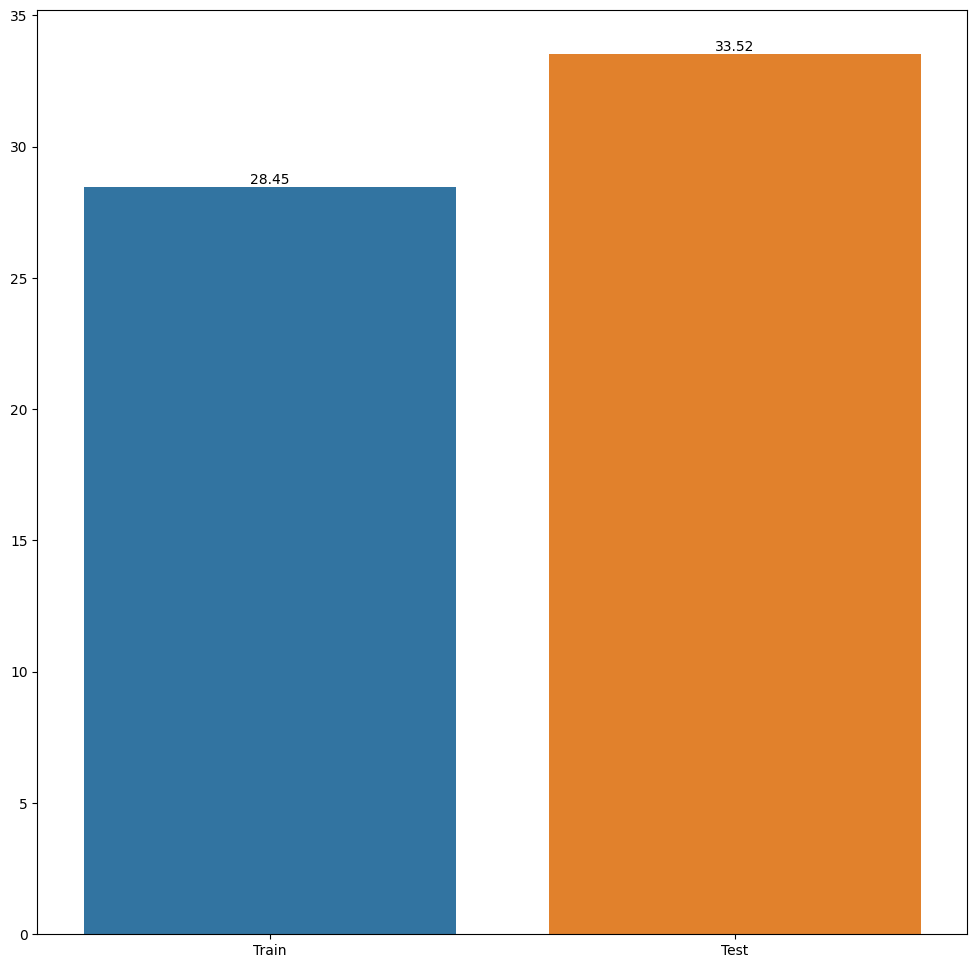

╭─────────────────────────────────────────────── Gini Change test ────────────────────────────────────────────────╮
│ ✅ Test passed with absolute and relative diffs: 5.07 p.p and 17.81%                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

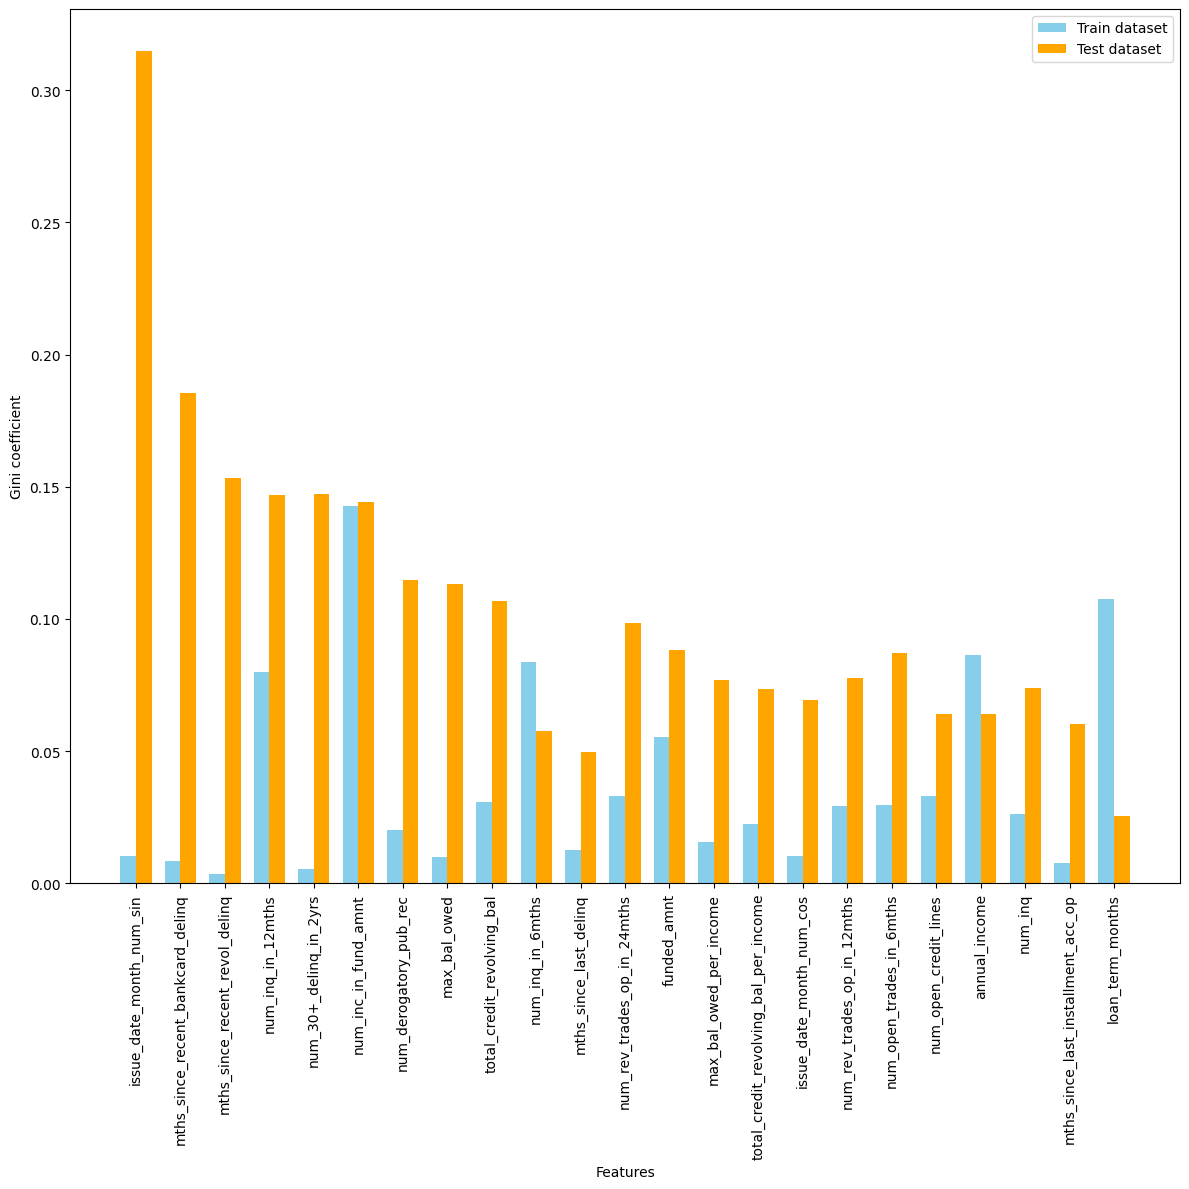

╭─────────────────────────────────────────── Features Gini Change test ───────────────────────────────────────────╮
│ ✅ Test passed with 0.00 , 0.04 , 0.96 shares for red, yellow, green scores                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── Final result ──────────────────────────────────────────────────╮
│ ❌ Validation failed                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [29]:
pipeline_model = Pipeline([
    ("preparator", FunctionTransformer(
        lambda X: pipeline.transform(X).astype(np.float32)
        )
    ),
    ("model", model)
])

validator.validate(
    X_val,
    y_val,
    model=pipeline_model,
    train_data=[X_train, y_train],

)

# Income calculation 

In [30]:
p_pred_test = model.predict_proba(X_test_trans.astype(np.float32))
p_pred_val = model.predict_proba(X_val_trans.astype(np.float32))

In [31]:
def process_results(res):
    res["Optimal Income"]["t"] = round(res["Optimal Income"]["t"], 5)
    res['Optimal Yield']["t"] = round(res['Optimal Yield']["t"], 5)
    res["Optimal Income"]["yield"] = round(res["Optimal Income"]["yield"], 5)
    res['Optimal Yield']["yield"] = round(res['Optimal Yield']["yield"], 5)
    return res

## Recovery rate $ = 0\%$

In [32]:
inc_pred = IncomePredictor(
    amount_col="funded_amnt",
    term_month_col="loan_term_months",
    recovery_rate=0,
    interest_rate=0.13,
)

Let's find the optimal value of threshold on the test sample 

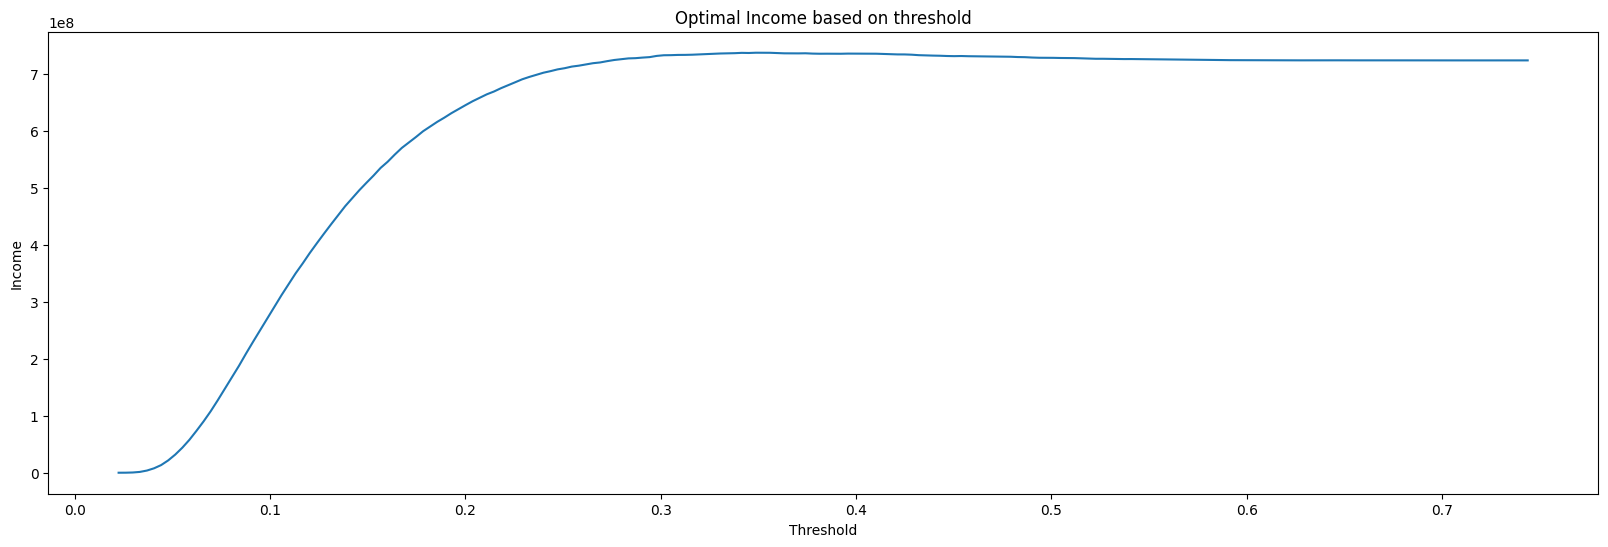

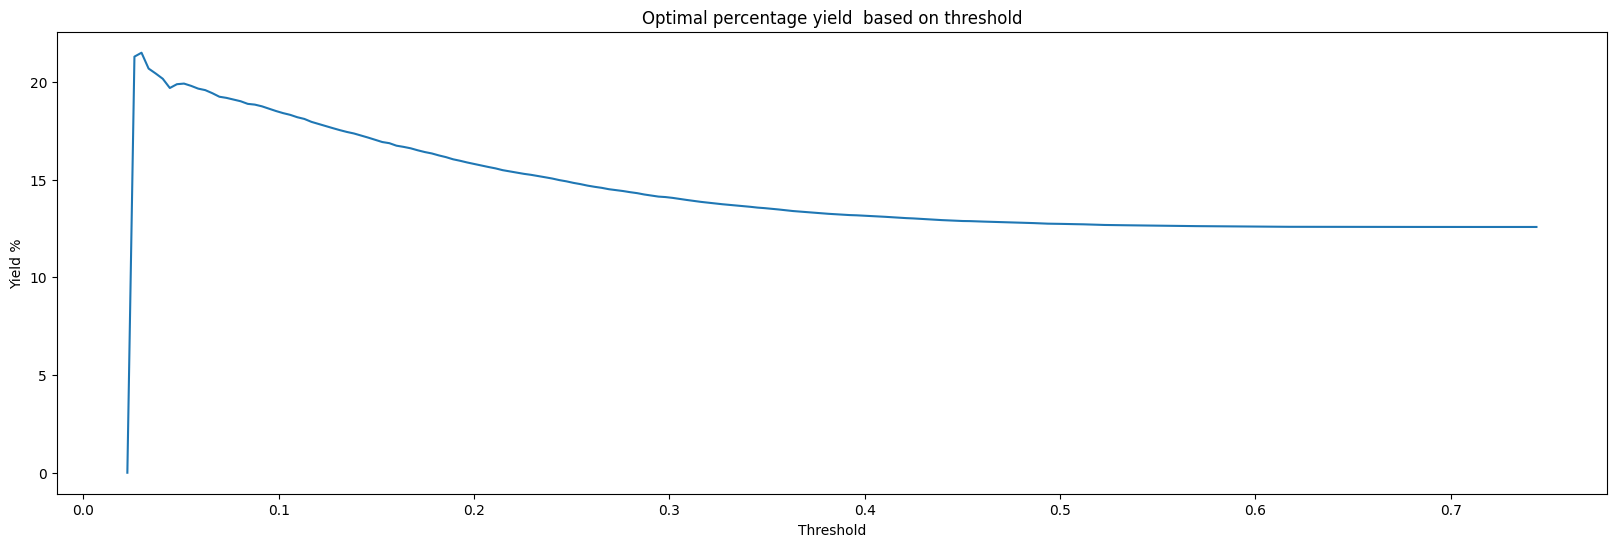

In [33]:
optimal_t_test = inc_pred.find_optimal_t(
    X_test,
    y_test,
    probs=p_pred_test,
    n_jobs=Config.n_jobs,
    plot=True,
    figsize=(20, 6),

)

In [34]:
process_results(optimal_t_test)

{'Optimal Income': {'t': 0.34874,
  'income': 736822400.0,
  'funded_sum': 5440646000.0,
  'yield': 13.54292},
 'Optimal Yield': {'t': 0.02972,
  'income': 408212.53125,
  'funded_sum': 1898825.0,
  'yield': 21.49816}}

Now let's check this t on the val sample 

In [35]:
val_income = inc_pred.calculate_income(
    X_val, 
    y_val,
    p_pred_val,
    optimal_t_test["Optimal Income"]["t"]
)

In [36]:
val_income

{'income': 1439062016.0, 'funded_sum': 6147765000.0}

Now let's look at the optimal t on the val sample 

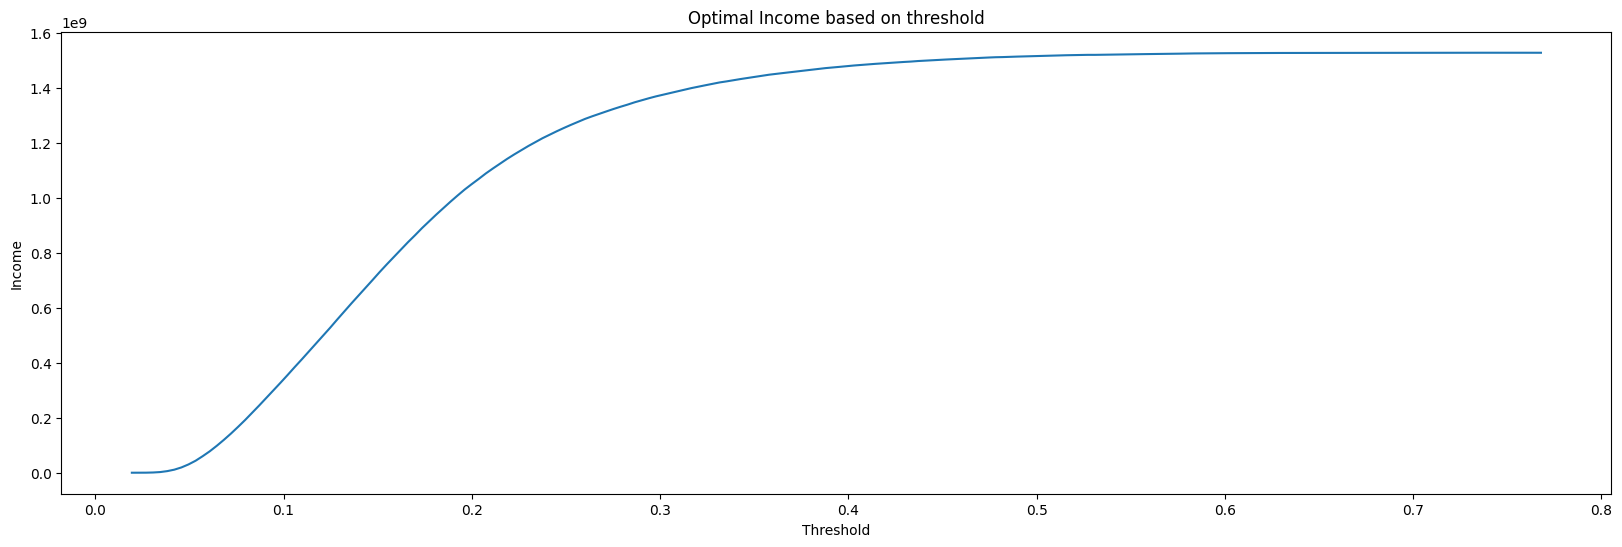

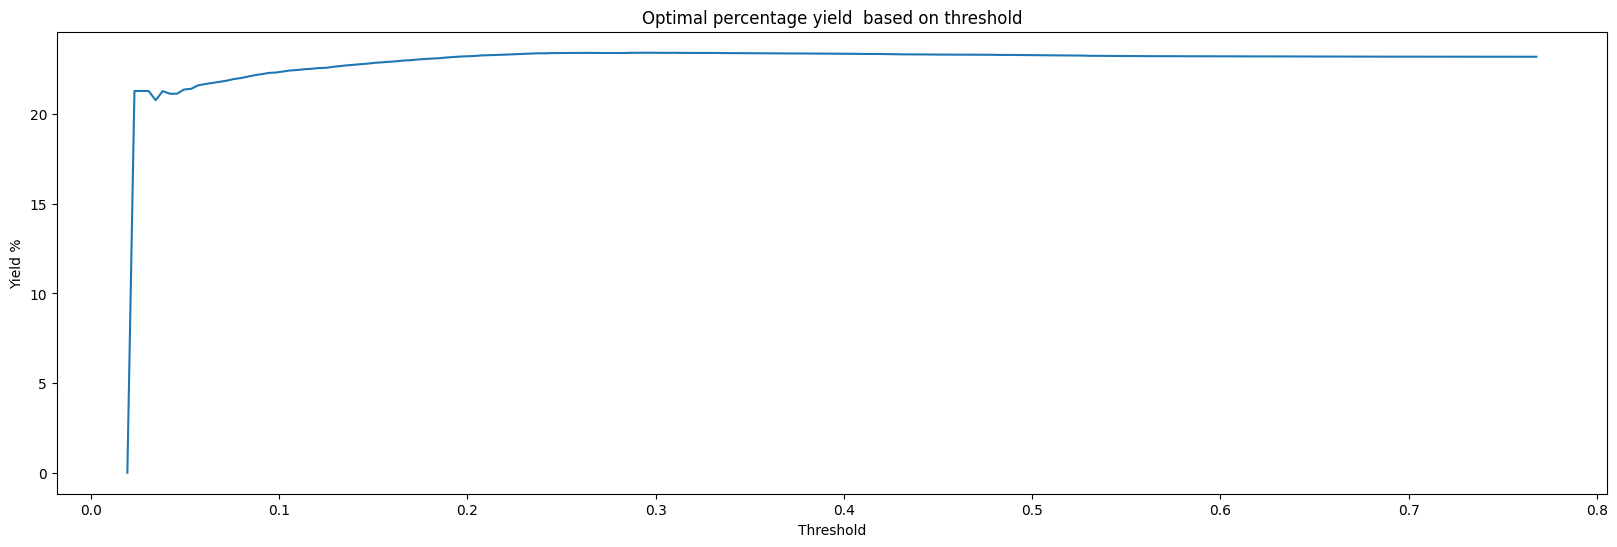

{'Optimal Income': {'t': 0.70396,
  'income': 1528563392.0,
  'funded_sum': 6585355300.0,
  'yield': 23.21156},
 'Optimal Yield': {'t': 0.29399,
  'income': 1362736448.0,
  'funded_sum': 5815686000.0,
  'yield': 23.43208}}

In [37]:
process_results(
    inc_pred.find_optimal_t(
        X_val,
        y_val,
        p_pred_val,
        n_jobs=Config.n_jobs,
        plot=True,
        figsize=(20, 6),
    )
)

## Recovery rate $ = 20\%$

In [38]:
inc_pred = IncomePredictor(
    amount_col="funded_amnt",
    term_month_col="loan_term_months",
    recovery_rate=0.2,
    interest_rate=0.13,
)

Let's repeat the same steps with a new recovery rate 

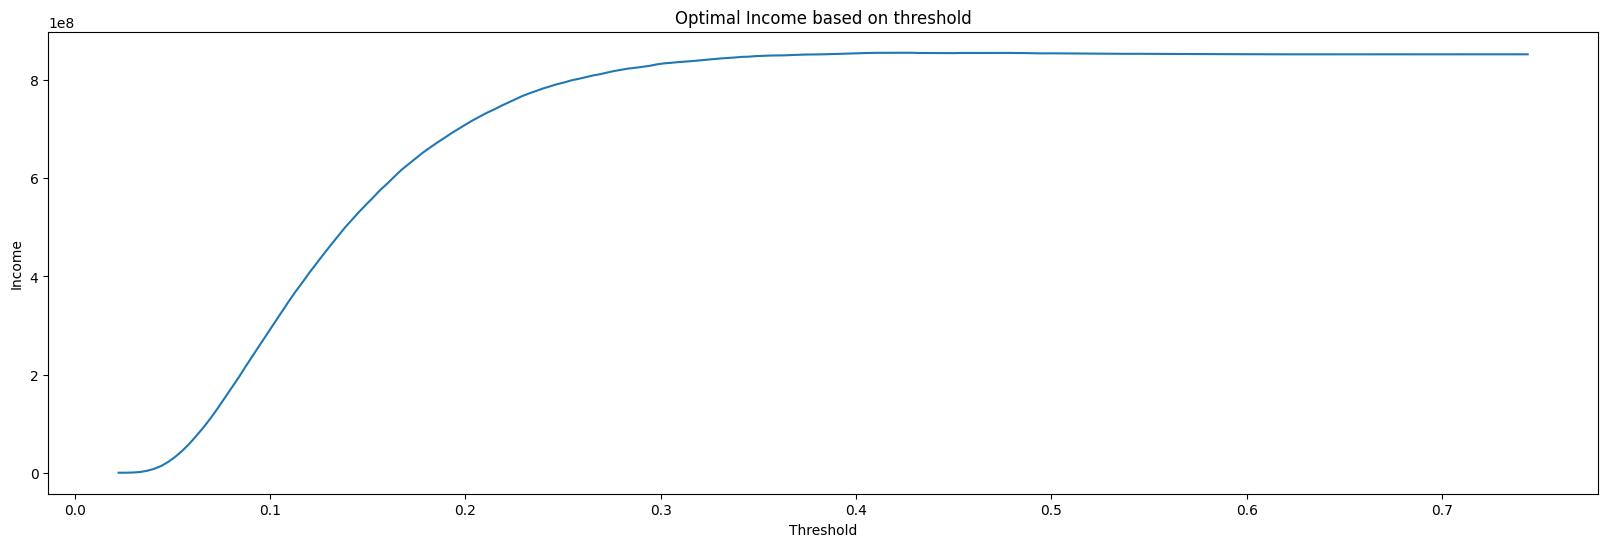

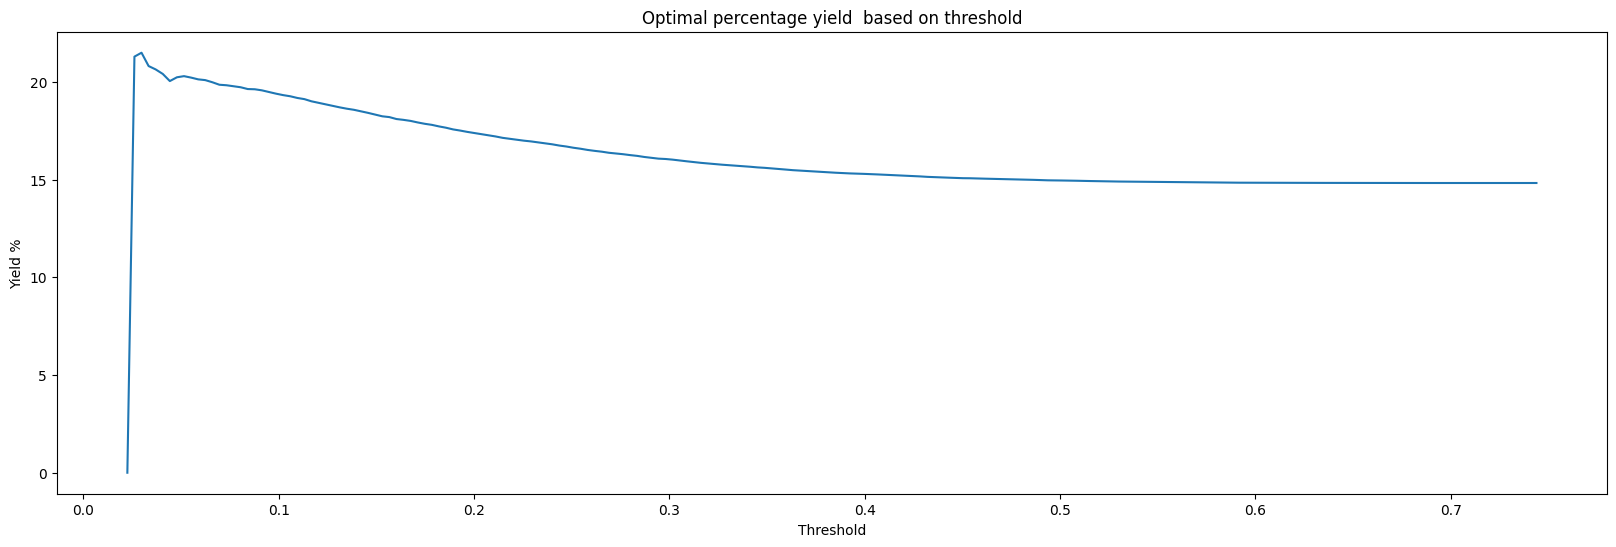

In [39]:
optimal_t_test = inc_pred.find_optimal_t(
    X_test,
    y_test,
    probs=p_pred_test,
    n_jobs=Config.n_jobs,
    plot=True,
    figsize=(20, 6),

)

In [40]:
process_results(optimal_t_test)

{'Optimal Income': {'t': 0.42487,
  'income': 856025190.4,
  'funded_sum': 5637625300.0,
  'yield': 15.18414},
 'Optimal Yield': {'t': 0.02972,
  'income': 408212.53125,
  'funded_sum': 1898825.0,
  'yield': 21.49816}}

In [41]:
val_income = inc_pred.calculate_income(
    X_val, 
    y_val,
    p_pred_val,
    optimal_t_test["Optimal Income"]["t"]
)

In [42]:
val_income

{'income': 1530707814.4, 'funded_sum': 6393916000.0}

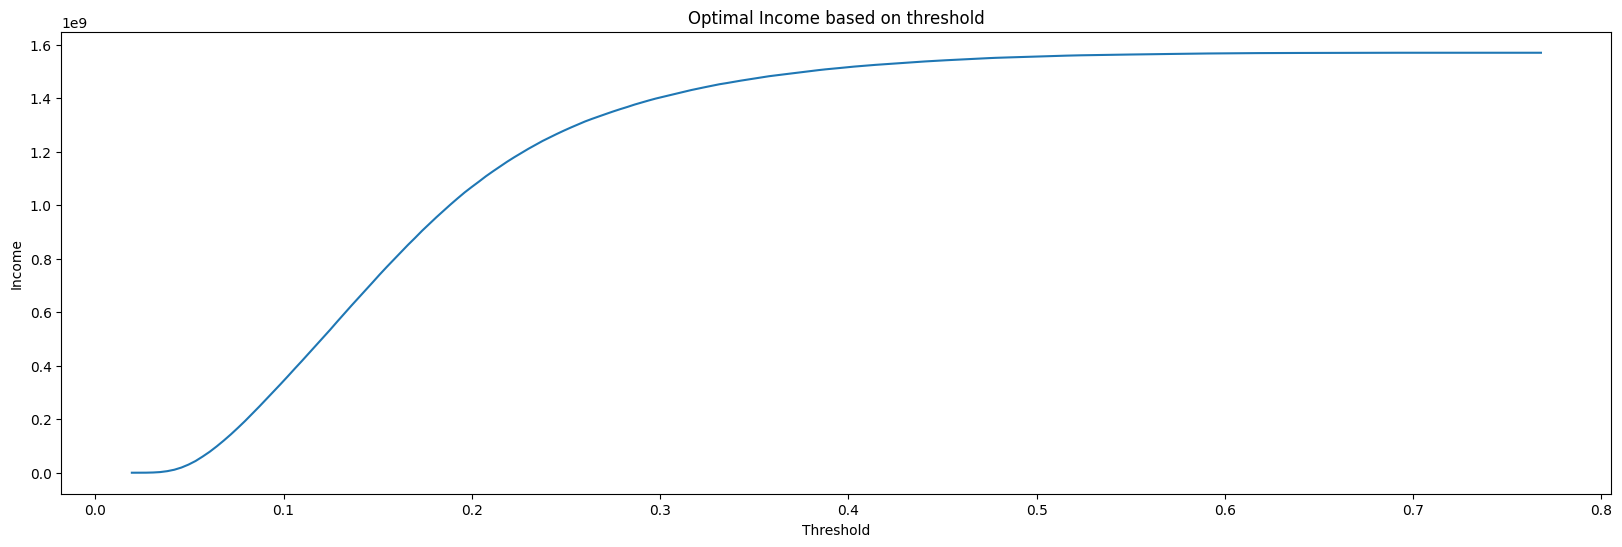

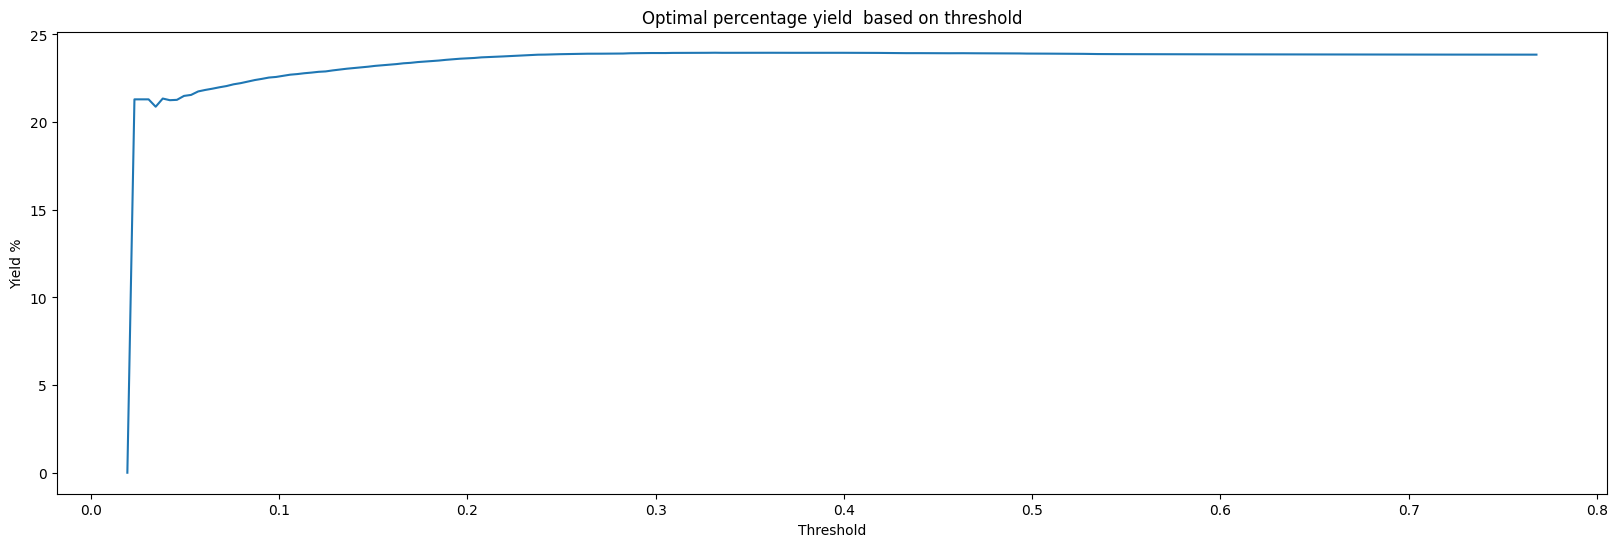

{'Optimal Income': {'t': 0.72277,
  'income': 1570682368.0,
  'funded_sum': 6585592000.0,
  'yield': 23.85028},
 'Optimal Yield': {'t': 0.33161,
  'income': 1452892492.8,
  'funded_sum': 6064403500.0,
  'yield': 23.95771}}

In [43]:
process_results(
    inc_pred.find_optimal_t(
        X_val,
        y_val,
        p_pred_val,
        n_jobs=Config.n_jobs,
        plot=True,
        figsize=(20, 6),
    )
)